# Необходимые модули

In [31]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Вспомогательные функции

In [3]:
def print_least_nan_value_index(data):
    for column in data.columns:
        print(data[data[column].isnull()].index.min(), column)
        
def print_least_missing_value_index(data):
    for column in data.columns:
        print(data[data[column] == -200].index.min(), column)
        
def print_count_nan_value_index(data):
    for column in data.columns:
        print(data[data[column].isnull()].index.size, column)
        
def print_count_missing_value_index(data):
    for column in data.columns:
        print(data[data[column] == -200].index.size, column)

# EDA

Загрузим данные и посмотрим на первую пятерку объектов:

In [4]:
air_quality_data_frame = pd.read_csv('AirQualityUCI/AirQualityUCI.csv', delimiter=';', header=0)

In [5]:
air_quality_data_frame.head()

Date      Time CO(GT)  PT08.S1(CO)  NMHC(GT) C6H6(GT)  PT08.S2(NMHC)  \
0  10/03/2004  18.00.00    2,6       1360.0     150.0     11,9         1046.0   
1  10/03/2004  19.00.00      2       1292.0     112.0      9,4          955.0   
2  10/03/2004  20.00.00    2,2       1402.0      88.0      9,0          939.0   
3  10/03/2004  21.00.00    2,2       1376.0      80.0      9,2          948.0   
4  10/03/2004  22.00.00    1,6       1272.0      51.0      6,5          836.0   

   NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH  \
0    166.0        1056.0    113.0        1692.0       1268.0  13,6  48,9   
1    103.0        1174.0     92.0        1559.0        972.0  13,3  47,7   
2    131.0        1140.0    114.0        1555.0       1074.0  11,9  54,0   
3    172.0        1092.0    122.0        1584.0       1203.0  11,0  60,0   
4    131.0        1205.0    116.0        1490.0       1110.0  11,2  59,6   

       AH  Unnamed: 15  Unnamed: 16  
0  0,7578          NaN          NaN  
1  0,7255          NaN          NaN  
2  0,7502          NaN          NaN  
3  0,7867          NaN          NaN  
4  0,7888          NaN          NaN

Первые два признака явно можно свести в один (Timestamp), в значениях признаков CO(GT), C6H6(GT), T, RH, AH целая часть отделена от дробной запятой, а не точкой, что, скорее всего, сказывается на типе, в котором эти признаки представлены в выборке. Также последние два признака, похоже, могут вообще никакой информации не содержать.

Взглянем на меры центральной тенденции, изменчивости и т.д.:

In [6]:
air_quality_data_frame.describe()

PT08.S1(CO)     NMHC(GT)  PT08.S2(NMHC)      NOx(GT)  PT08.S3(NOx)  \
count  9357.000000  9357.000000    9357.000000  9357.000000   9357.000000   
mean   1048.990061  -159.090093     894.595276   168.616971    794.990168   
std     329.832710   139.789093     342.333252   257.433866    321.993552   
min    -200.000000  -200.000000    -200.000000  -200.000000   -200.000000   
25%     921.000000  -200.000000     711.000000    50.000000    637.000000   
50%    1053.000000  -200.000000     895.000000   141.000000    794.000000   
75%    1221.000000  -200.000000    1105.000000   284.000000    960.000000   
max    2040.000000  1189.000000    2214.000000  1479.000000   2683.000000   

           NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  Unnamed: 15  Unnamed: 16  
count  9357.000000   9357.000000  9357.000000          0.0          0.0  
mean     58.148873   1391.479641   975.072032          NaN          NaN  
std     126.940455    467.210125   456.938184          NaN          NaN  
min    -200.000000   -200.000000  -200.000000          NaN          NaN  
25%      53.000000   1185.000000   700.000000          NaN          NaN  
50%      96.000000   1446.000000   942.000000          NaN          NaN  
75%     133.000000   1662.000000  1255.000000          NaN          NaN  
max     340.000000   2775.000000  2523.000000          NaN          NaN

Итак, примечательно, что порядок максимальных значений для признака NO2(GT) отличается от прочих на единицу, необходимо будет нормализовать значения признаков. Кроме того, последние два признака целиком состоят из NaN-ов. Собственно, их можно удалять из выборки. Также стоит отметить, что в сформированной таблице отсутствуют статистики по ряду признаков (например T, RH, AH). Это говорит о том, что значения данных признаков загружены не в числовом формате, необходимо будет их в него преобразовать.

Выведем еще немного информации по датасету:

In [7]:
air_quality_data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
Date             9357 non-null object
Time             9357 non-null object
CO(GT)           9357 non-null object
PT08.S1(CO)      9357 non-null float64
NMHC(GT)         9357 non-null float64
C6H6(GT)         9357 non-null object
PT08.S2(NMHC)    9357 non-null float64
NOx(GT)          9357 non-null float64
PT08.S3(NOx)     9357 non-null float64
NO2(GT)          9357 non-null float64
PT08.S4(NO2)     9357 non-null float64
PT08.S5(O3)      9357 non-null float64
T                9357 non-null object
RH               9357 non-null object
AH               9357 non-null object
Unnamed: 15      0 non-null float64
Unnamed: 16      0 non-null float64
dtypes: float64(10), object(7)
memory usage: 1.2+ MB


Отметим, что вышеупомянутые признаки (CO(GT), C6H6(GT), T, RH, AH) имеют тип object, хотя по идее должны были быть типа float64. 

Удалим из датасета два последний признака, поскольку они не представляют никакой ценности:

In [8]:
air_quality_data_frame_remove_nan_v_1 = air_quality_data_frame.dropna(axis=1, how='all')

В предыдущей ячейке показано, что объектов в выборке 9471, однако каждый (теперь уже без исключений) признак в выборке имеет только 9357 непустых значений. Вообще говоря, эти 114 пропусков для каждого признака могут быть расположены в разных объектах. Необходимо понять, как они распределены.

Выведем для начала для каждого признака ниаменьший иднекс объекта, на котором значение данного признака пропущено:

In [9]:
print_least_nan_value_index(air_quality_data_frame_remove_nan_v_1)

(9357, 'Date')
(9357, 'Time')
(9357, 'CO(GT)')
(9357, 'PT08.S1(CO)')
(9357, 'NMHC(GT)')
(9357, 'C6H6(GT)')
(9357, 'PT08.S2(NMHC)')
(9357, 'NOx(GT)')
(9357, 'PT08.S3(NOx)')
(9357, 'NO2(GT)')
(9357, 'PT08.S4(NO2)')
(9357, 'PT08.S5(O3)')
(9357, 'T')
(9357, 'RH')
(9357, 'AH')


In [10]:
print_count_nan_value_index(air_quality_data_frame_remove_nan_v_1)

(114, 'Date')
(114, 'Time')
(114, 'CO(GT)')
(114, 'PT08.S1(CO)')
(114, 'NMHC(GT)')
(114, 'C6H6(GT)')
(114, 'PT08.S2(NMHC)')
(114, 'NOx(GT)')
(114, 'PT08.S3(NOx)')
(114, 'NO2(GT)')
(114, 'PT08.S4(NO2)')
(114, 'PT08.S5(O3)')
(114, 'T')
(114, 'RH')
(114, 'AH')


Получается, что для всех признаков в датасете пропуски начинаются с 9358-го объекта, следовательно предыдущие объекты пропусков не имеют. 

Удаляем пустые строки:

In [11]:
air_quality_data_frame_remove_nan_v_2 = air_quality_data_frame_remove_nan_v_1.dropna(axis='index', how='any')

Теперь нужно поправить признаки с запятой в качестве разделителя:

In [12]:
air_quality_data_frame_remove_nan_v_2_CO_GT = air_quality_data_frame_remove_nan_v_2.loc[:, 'CO(GT)'].apply(lambda x: float(str(x).replace(',', '.')))
air_quality_data_frame_remove_nan_v_2_C6H6_GT = air_quality_data_frame_remove_nan_v_2.loc[:, 'C6H6(GT)'].apply(lambda x: float(str(x).replace(',', '.')))
air_quality_data_frame_remove_nan_v_2_T = air_quality_data_frame_remove_nan_v_2.loc[:, 'T'].apply(lambda x: float(str(x).replace(',', '.')))
air_quality_data_frame_remove_nan_v_2_RH = air_quality_data_frame_remove_nan_v_2.loc[:, 'RH'].apply(lambda x: float(str(x).replace(',', '.')))
air_quality_data_frame_remove_nan_v_2_AH = air_quality_data_frame_remove_nan_v_2.loc[:, 'AH'].apply(lambda x: float(str(x).replace(',', '.')))

Сформируем новый датасет, удалив из старого вышеупомянутые признаки и совместив остаток с их преобразованиями:

In [13]:
air_quality_data_frame_remove_nan_v_2 = pd.concat([
    air_quality_data_frame_remove_nan_v_2.drop(['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH'], axis='columns'),
    air_quality_data_frame_remove_nan_v_2_CO_GT,
    air_quality_data_frame_remove_nan_v_2_C6H6_GT,
    air_quality_data_frame_remove_nan_v_2_T,
    air_quality_data_frame_remove_nan_v_2_RH,
    air_quality_data_frame_remove_nan_v_2_AH
], axis='columns')

In [14]:
air_quality_data_frame_remove_nan_v_2.head()

Date      Time  PT08.S1(CO)  NMHC(GT)  PT08.S2(NMHC)  NOx(GT)  \
0  10/03/2004  18.00.00       1360.0     150.0         1046.0    166.0   
1  10/03/2004  19.00.00       1292.0     112.0          955.0    103.0   
2  10/03/2004  20.00.00       1402.0      88.0          939.0    131.0   
3  10/03/2004  21.00.00       1376.0      80.0          948.0    172.0   
4  10/03/2004  22.00.00       1272.0      51.0          836.0    131.0   

   PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  CO(GT)  C6H6(GT)     T  \
0        1056.0    113.0        1692.0       1268.0     2.6      11.9  13.6   
1        1174.0     92.0        1559.0        972.0     2.0       9.4  13.3   
2        1140.0    114.0        1555.0       1074.0     2.2       9.0  11.9   
3        1092.0    122.0        1584.0       1203.0     2.2       9.2  11.0   
4        1205.0    116.0        1490.0       1110.0     1.6       6.5  11.2   

     RH      AH  
0  48.9  0.7578  
1  47.7  0.7255  
2  54.0  0.7502  
3  60.0  0.7867  
4  59.6  0.7888

In [15]:
air_quality_data_frame_remove_nan_v_2.describe()

PT08.S1(CO)     NMHC(GT)  PT08.S2(NMHC)      NOx(GT)  PT08.S3(NOx)  \
count  9357.000000  9357.000000    9357.000000  9357.000000   9357.000000   
mean   1048.990061  -159.090093     894.595276   168.616971    794.990168   
std     329.832710   139.789093     342.333252   257.433866    321.993552   
min    -200.000000  -200.000000    -200.000000  -200.000000   -200.000000   
25%     921.000000  -200.000000     711.000000    50.000000    637.000000   
50%    1053.000000  -200.000000     895.000000   141.000000    794.000000   
75%    1221.000000  -200.000000    1105.000000   284.000000    960.000000   
max    2040.000000  1189.000000    2214.000000  1479.000000   2683.000000   

           NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)       CO(GT)     C6H6(GT)  \
count  9357.000000   9357.000000  9357.000000  9357.000000  9357.000000   
mean     58.148873   1391.479641   975.072032   -34.207524     1.865683   
std     126.940455    467.210125   456.938184    77.657170    41.380206   
min    -200.000000   -200.000000  -200.000000  -200.000000  -200.000000   
25%      53.000000   1185.000000   700.000000     0.600000     4.000000   
50%      96.000000   1446.000000   942.000000     1.500000     7.900000   
75%     133.000000   1662.000000  1255.000000     2.600000    13.600000   
max     340.000000   2775.000000  2523.000000    11.900000    63.700000   

                 T           RH           AH  
count  9357.000000  9357.000000  9357.000000  
mean      9.778305    39.485380    -6.837604  
std      43.203623    51.216145    38.976670  
min    -200.000000  -200.000000  -200.000000  
25%      10.900000    34.100000     0.692300  
50%      17.200000    48.600000     0.976800  
75%      24.100000    61.900000     1.296200  
max      44.600000    88.700000     2.231000

In [16]:
air_quality_data_frame_remove_nan_v_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 15 columns):
Date             9357 non-null object
Time             9357 non-null object
PT08.S1(CO)      9357 non-null float64
NMHC(GT)         9357 non-null float64
PT08.S2(NMHC)    9357 non-null float64
NOx(GT)          9357 non-null float64
PT08.S3(NOx)     9357 non-null float64
NO2(GT)          9357 non-null float64
PT08.S4(NO2)     9357 non-null float64
PT08.S5(O3)      9357 non-null float64
CO(GT)           9357 non-null float64
C6H6(GT)         9357 non-null float64
T                9357 non-null float64
RH               9357 non-null float64
AH               9357 non-null float64
dtypes: float64(13), object(2)
memory usage: 1.1+ MB


Как видно из двух верхних ячеек теперь признаки CO(GT), C6H6(GT), T, RH, AH имеют числовой тип.

Теперь совместим первые два признака с один и сделаем его индексом:

In [17]:
air_quality_data_frame_remove_nan_v_2_Time = air_quality_data_frame_remove_nan_v_2.loc[:, 'Time'].apply(lambda x: str(x).replace('.', ':'))

In [18]:
air_quality_data_frame_remove_nan_v_2_Timestamp = pd.concat(
    [
        air_quality_data_frame_remove_nan_v_2['Date'],
        air_quality_data_frame_remove_nan_v_2_Time
    ], axis='columns').apply(lambda x: pd.to_datetime(x[0] + ' ' + x[1]), axis='columns')

In [19]:
air_quality_data_frame_remove_nan_v_3 = pd.concat([
    air_quality_data_frame_remove_nan_v_2_Timestamp.rename('Timestamp', inplace=True),
    air_quality_data_frame_remove_nan_v_2.drop(['Date', 'Time'], axis='columns')
], axis='columns')

In [20]:
air_quality_data_frame_remove_nan_v_3.index = air_quality_data_frame_remove_nan_v_3.Timestamp

In [21]:
air_quality_data_frame_remove_nan_v_3.drop('Timestamp', inplace=True, axis='columns')

In [22]:
air_quality_data_frame_remove_nan_v_3.head()

PT08.S1(CO)  NMHC(GT)  PT08.S2(NMHC)  NOx(GT)  \
Timestamp                                                            
2004-10-03 18:00:00       1360.0     150.0         1046.0    166.0   
2004-10-03 19:00:00       1292.0     112.0          955.0    103.0   
2004-10-03 20:00:00       1402.0      88.0          939.0    131.0   
2004-10-03 21:00:00       1376.0      80.0          948.0    172.0   
2004-10-03 22:00:00       1272.0      51.0          836.0    131.0   

                     PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  CO(GT)  \
Timestamp                                                                       
2004-10-03 18:00:00        1056.0    113.0        1692.0       1268.0     2.6   
2004-10-03 19:00:00        1174.0     92.0        1559.0        972.0     2.0   
2004-10-03 20:00:00        1140.0    114.0        1555.0       1074.0     2.2   
2004-10-03 21:00:00        1092.0    122.0        1584.0       1203.0     2.2   
2004-10-03 22:00:00        1205.0    116.0        1490.0       1110.0     1.6   

                     C6H6(GT)     T    RH      AH  
Timestamp                                          
2004-10-03 18:00:00      11.9  13.6  48.9  0.7578  
2004-10-03 19:00:00       9.4  13.3  47.7  0.7255  
2004-10-03 20:00:00       9.0  11.9  54.0  0.7502  
2004-10-03 21:00:00       9.2  11.0  60.0  0.7867  
2004-10-03 22:00:00       6.5  11.2  59.6  0.7888

In [23]:
air_quality_data_frame_remove_nan_v_3.describe()

PT08.S1(CO)     NMHC(GT)  PT08.S2(NMHC)      NOx(GT)  PT08.S3(NOx)  \
count  9357.000000  9357.000000    9357.000000  9357.000000   9357.000000   
mean   1048.990061  -159.090093     894.595276   168.616971    794.990168   
std     329.832710   139.789093     342.333252   257.433866    321.993552   
min    -200.000000  -200.000000    -200.000000  -200.000000   -200.000000   
25%     921.000000  -200.000000     711.000000    50.000000    637.000000   
50%    1053.000000  -200.000000     895.000000   141.000000    794.000000   
75%    1221.000000  -200.000000    1105.000000   284.000000    960.000000   
max    2040.000000  1189.000000    2214.000000  1479.000000   2683.000000   

           NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)       CO(GT)     C6H6(GT)  \
count  9357.000000   9357.000000  9357.000000  9357.000000  9357.000000   
mean     58.148873   1391.479641   975.072032   -34.207524     1.865683   
std     126.940455    467.210125   456.938184    77.657170    41.380206   
min    -200.000000   -200.000000  -200.000000  -200.000000  -200.000000   
25%      53.000000   1185.000000   700.000000     0.600000     4.000000   
50%      96.000000   1446.000000   942.000000     1.500000     7.900000   
75%     133.000000   1662.000000  1255.000000     2.600000    13.600000   
max     340.000000   2775.000000  2523.000000    11.900000    63.700000   

                 T           RH           AH  
count  9357.000000  9357.000000  9357.000000  
mean      9.778305    39.485380    -6.837604  
std      43.203623    51.216145    38.976670  
min    -200.000000  -200.000000  -200.000000  
25%      10.900000    34.100000     0.692300  
50%      17.200000    48.600000     0.976800  
75%      24.100000    61.900000     1.296200  
max      44.600000    88.700000     2.231000

In [24]:
air_quality_data_frame_remove_nan_v_3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9357 entries, 2004-10-03 18:00:00 to 2005-04-04 14:00:00
Data columns (total 13 columns):
PT08.S1(CO)      9357 non-null float64
NMHC(GT)         9357 non-null float64
PT08.S2(NMHC)    9357 non-null float64
NOx(GT)          9357 non-null float64
PT08.S3(NOx)     9357 non-null float64
NO2(GT)          9357 non-null float64
PT08.S4(NO2)     9357 non-null float64
PT08.S5(O3)      9357 non-null float64
CO(GT)           9357 non-null float64
C6H6(GT)         9357 non-null float64
T                9357 non-null float64
RH               9357 non-null float64
AH               9357 non-null float64
dtypes: float64(13)
memory usage: 1023.4 KB


По сравнению с первоначальным датасетом текущий его вариант использует примерно на пару сотен КБ меньше. Так же теперь все признаки имеют вполне конкретный тип.

Из описания датасета можно вынести, что отсутствующие значения так же помечены как -200. Взглянем, как много таких значений и где они расположены:

In [25]:
print_least_missing_value_index(air_quality_data_frame_remove_nan_v_3)

(Timestamp('2004-01-04 14:00:00'), 'PT08.S1(CO)')
(Timestamp('2004-01-05 01:00:00'), 'NMHC(GT)')
(Timestamp('2004-01-04 14:00:00'), 'PT08.S2(NMHC)')
(Timestamp('2004-01-04 03:00:00'), 'NOx(GT)')
(Timestamp('2004-01-04 14:00:00'), 'PT08.S3(NOx)')
(Timestamp('2004-01-04 03:00:00'), 'NO2(GT)')
(Timestamp('2004-01-04 14:00:00'), 'PT08.S4(NO2)')
(Timestamp('2004-01-04 14:00:00'), 'PT08.S5(O3)')
(Timestamp('2004-01-05 04:00:00'), 'CO(GT)')
(Timestamp('2004-01-04 14:00:00'), 'C6H6(GT)')
(Timestamp('2004-01-04 14:00:00'), 'T')
(Timestamp('2004-01-04 14:00:00'), 'RH')
(Timestamp('2004-01-04 14:00:00'), 'AH')


In [26]:
print_count_missing_value_index(air_quality_data_frame_remove_nan_v_3)

(366, 'PT08.S1(CO)')
(8443, 'NMHC(GT)')
(366, 'PT08.S2(NMHC)')
(1639, 'NOx(GT)')
(366, 'PT08.S3(NOx)')
(1642, 'NO2(GT)')
(366, 'PT08.S4(NO2)')
(366, 'PT08.S5(O3)')
(1683, 'CO(GT)')
(366, 'C6H6(GT)')
(366, 'T')
(366, 'RH')
(366, 'AH')


Сформируем другой датасет, заменив все значения -200 Nan-ами:

In [28]:
air_quality_data_frame_remove_nan_v_3 = air_quality_data_frame_remove_nan_v_3.replace(-200, numpy.NaN)

In [30]:
air_quality_data_frame_remove_nan_v_3.describe()

PT08.S1(CO)     NMHC(GT)  PT08.S2(NMHC)      NOx(GT)  PT08.S3(NOx)  \
count  8991.000000   914.000000    8991.000000  7718.000000   8991.000000   
mean   1099.833166   218.811816     939.153376   246.896735    835.493605   
std     217.080037   204.459921     266.831429   212.979168    256.817320   
min     647.000000     7.000000     383.000000     2.000000    322.000000   
25%     937.000000    67.000000     734.500000    98.000000    658.000000   
50%    1063.000000   150.000000     909.000000   180.000000    806.000000   
75%    1231.000000   297.000000    1116.000000   326.000000    969.500000   
max    2040.000000  1189.000000    2214.000000  1479.000000   2683.000000   

           NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)       CO(GT)     C6H6(GT)  \
count  7715.000000   8991.000000  8991.000000  7674.000000  8991.000000   
mean    113.091251   1456.264598  1022.906128     2.152750    10.083105   
std      48.370108    346.206794   398.484288     1.453252     7.449820   
min       2.000000    551.000000   221.000000     0.100000     0.100000   
25%      78.000000   1227.000000   731.500000     1.100000     4.400000   
50%     109.000000   1463.000000   963.000000     1.800000     8.200000   
75%     142.000000   1674.000000  1273.500000     2.900000    14.000000   
max     340.000000   2775.000000  2523.000000    11.900000    63.700000   

                 T           RH           AH  
count  8991.000000  8991.000000  8991.000000  
mean     18.317829    49.234201     1.025530  
std       8.832116    17.316892     0.403813  
min      -1.900000     9.200000     0.184700  
25%      11.800000    35.800000     0.736800  
50%      17.800000    49.600000     0.995400  
75%      24.400000    62.500000     1.313700  
max      44.600000    88.700000     2.231000

Как видно из таблицы, минимальные значения поменялись и количества значений для признаков теперь тоже разные. Воспользуемся стандартным классом из scikit-learn для заполнения этих пропусков:

In [33]:
imputer = preprocessing.Imputer()
air_quality_data_frame_remove_nan_v_3 = pd.DataFrame(
    data=imputer.fit_transform(air_quality_data_frame_remove_nan_v_3.values),
    index=air_quality_data_frame_remove_nan_v_3.index,
    columns=air_quality_data_frame_remove_nan_v_3.columns
)

In [34]:
air_quality_data_frame_remove_nan_v_3.describe()

PT08.S1(CO)     NMHC(GT)  PT08.S2(NMHC)      NOx(GT)  PT08.S3(NOx)  \
count  9357.000000  9357.000000    9357.000000  9357.000000   9357.000000   
mean   1099.833166   218.811816     939.153376   246.896735    835.493605   
std     212.791672    63.870229     261.560236   193.426632    251.743954   
min     647.000000     7.000000     383.000000     2.000000    322.000000   
25%     941.000000   218.811816     743.000000   112.000000    666.000000   
50%    1075.000000   218.811816     923.000000   229.000000    818.000000   
75%    1221.000000   218.811816    1105.000000   284.000000    960.000000   
max    2040.000000  1189.000000    2214.000000  1479.000000   2683.000000   

           NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)       CO(GT)     C6H6(GT)  \
count  9357.000000   9357.000000  9357.000000  9357.000000  9357.000000   
mean    113.091251   1456.264598  1022.906128     2.152750    10.083105   
std      43.920954    339.367559   390.612324     1.316068     7.302650   
min       2.000000    551.000000   221.000000     0.100000     0.100000   
25%      86.000000   1242.000000   742.000000     1.200000     4.600000   
50%     113.091251   1456.264598   983.000000     2.152750     8.600000   
75%     133.000000   1662.000000  1255.000000     2.600000    13.600000   
max     340.000000   2775.000000  2523.000000    11.900000    63.700000   

                 T           RH           AH  
count  9357.000000  9357.000000  9357.000000  
mean     18.317829    49.234201     1.025530  
std       8.657639    16.974801     0.395835  
min      -1.900000     9.200000     0.184700  
25%      12.000000    36.600000     0.746100  
50%      18.300000    49.234201     1.015400  
75%      24.100000    61.900000     1.296200  
max      44.600000    88.700000     2.231000

Итак, по умолчанию Imputer заменил пропуски средними значениями соответствующих признаков.

Взглянем на то, присутствуют ли в данных какие-нибудь взаимосвязи:

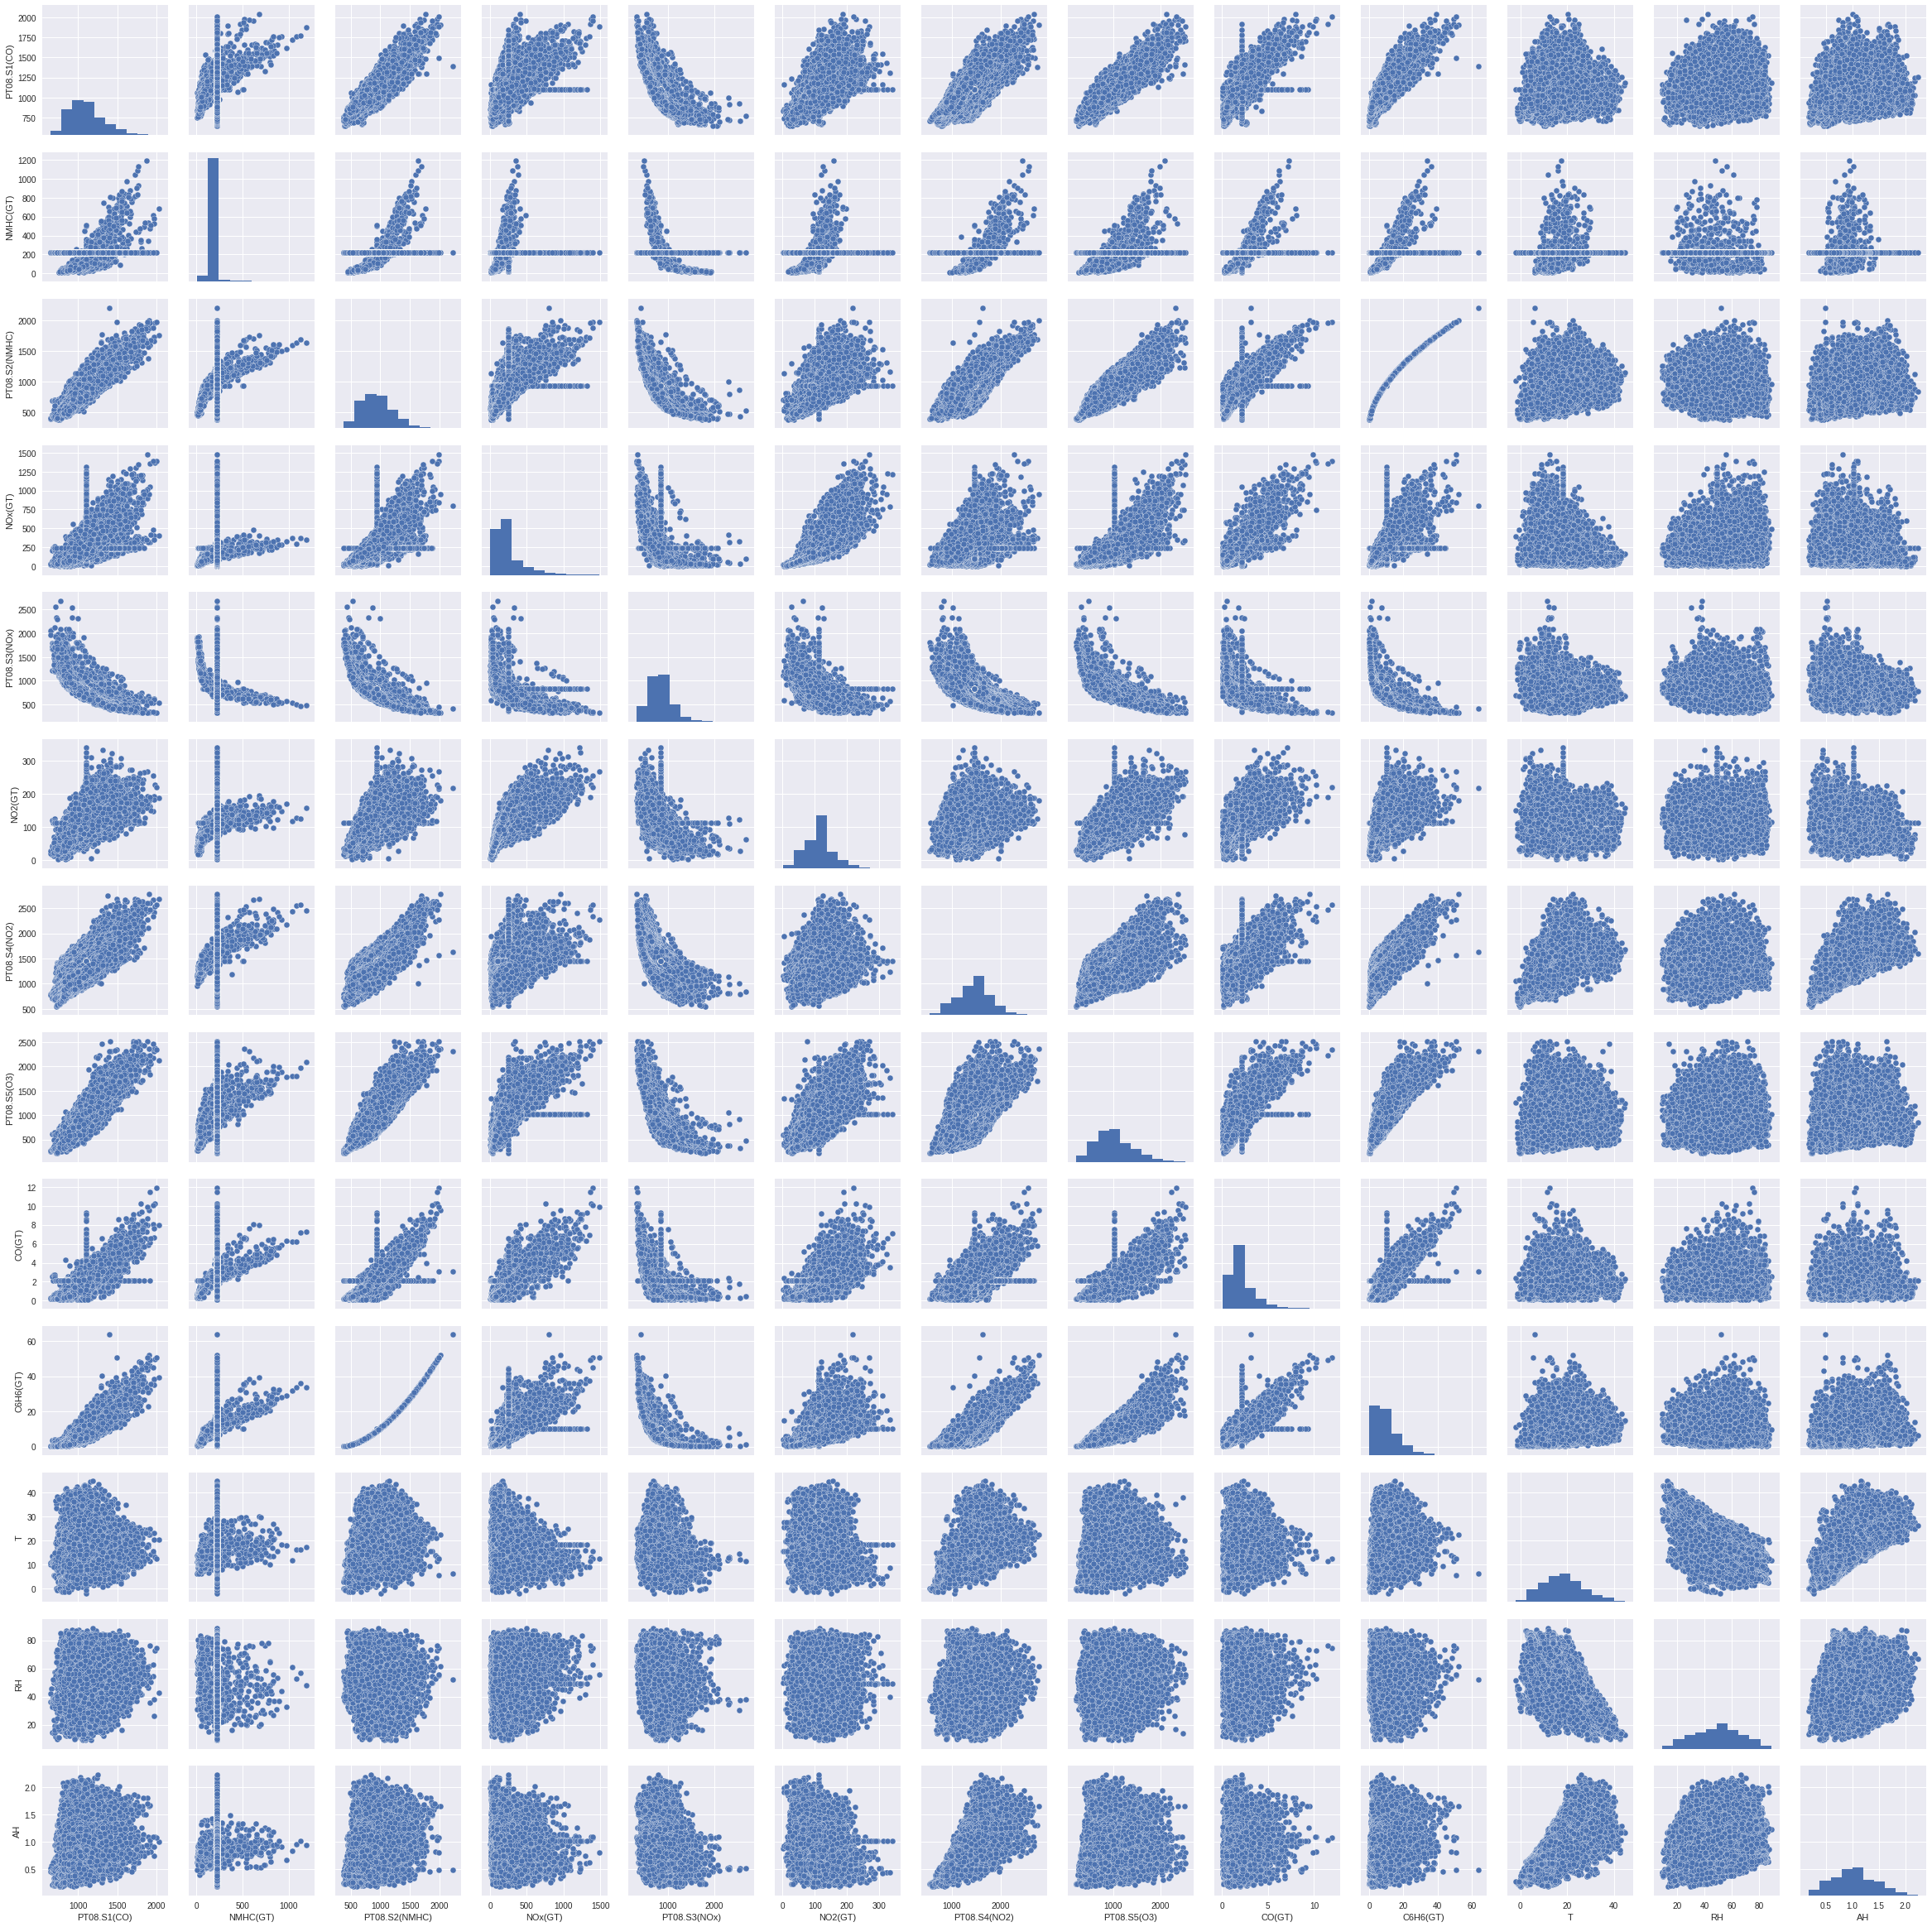

In [35]:
sns.pairplot(air_quality_data_frame_remove_nan_v_3)
plt.show()

На данной диаграмме рассеивания видно, что распределение подавляющего большинства признаков имеют довольно сильно выраженную асимметрию. Так же признаки содержат большое количество выбросов, что может плохо сказаться на регрессии.

Взглянем на степень линейной взаимосвязи признаков:

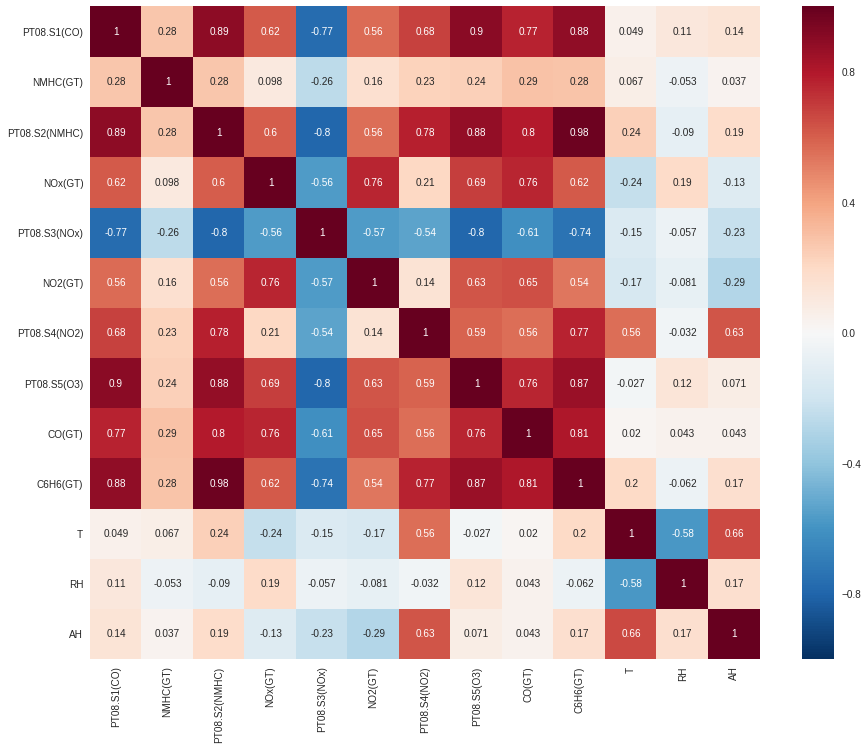

In [36]:
corr = air_quality_data_frame_remove_nan_v_3.corr()
plt.figure(figsize = (15, 12))
sns.heatmap(corr.applymap(lambda x: round(x, 4)), xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)

plt.xticks(rotation=90) 
plt.yticks(rotation=0) 
plt.show()

Можно заметить, что большое количество высоких положительных показателей коэффициента корреляции сильно снизились (ввиду отсутствия влияния выбросов). Ввиду этого же фактора появились довольно высокие показатели отрицательной связи (например, признаки C6H6(GT) и NOx(GT)).

In [37]:
Y = air_quality_data_frame_remove_nan_v_3['C6H6(GT)']
X = air_quality_data_frame_remove_nan_v_3.drop('C6H6(GT)', axis='columns')

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=0)

# Нелинейные преобразования

In [39]:
quantile_transformer = preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
X_train_trans = quantile_transformer.fit_transform(X_train)
X_test_trans = quantile_transformer.transform(X_test)

# Нормализация

In [40]:
robust_scaler = preprocessing.RobustScaler()
X_train_scaled = robust_scaler.fit_transform(X_train_trans)
X_test_scaled = robust_scaler.transform(X_test_trans)

In [41]:
df_X_train_scaled = pd.DataFrame(data=X_train_scaled, index=X_train.index)
df_X_train_scaled.columns = X.columns

df_X_test_scaled = pd.DataFrame(data=X_test_scaled, index=X_test.index)
df_X_test_scaled.columns = X.columns

In [42]:
df_X_train_scaled.describe()

PT08.S1(CO)     NMHC(GT)  PT08.S2(NMHC)      NOx(GT)  PT08.S3(NOx)  \
count  6269.000000  6269.000000    6269.000000  6269.000000   6269.000000   
mean      0.000905    -0.052746      -0.000379     0.001375      0.000920   
std       0.744260     0.659981       0.743993     0.743357      0.743273   
min      -3.857848    -5.236984      -3.854274    -3.857848     -3.853344   
25%      -0.499069     0.000000      -0.500584    -0.499069     -0.499654   
50%       0.000000     0.000000       0.000000     0.000000      0.000000   
75%       0.500931     0.000000       0.499416     0.500931      0.500346   
max       3.859710     5.161692       3.854274     3.859710      3.855204   

           NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)       CO(GT)            T  \
count  6269.000000   6269.000000  6269.000000  6269.000000  6269.000000   
mean     -0.056020      0.007397    -0.000854    -0.142958     0.001765   
std       0.741846      0.744216     0.742542     0.743045     0.740153   
min      -3.906494     -3.852564    -3.847451    -3.889941    -3.834487   
25%      -0.555553     -0.493556    -0.501672    -0.649058    -0.498731   
50%       0.000000      0.000000     0.000000     0.000000     0.000000   
75%       0.444447      0.506444     0.498328     0.350942     0.501269   
max       3.793054      3.867467     3.845594     3.614844     3.838189   

                RH           AH  
count  6269.000000  6269.000000  
mean      0.022090     0.000391  
std       0.744000     0.743213  
min      -3.836424    -3.855157  
25%      -0.476482    -0.499382  
50%       0.000000     0.000000  
75%       0.523518     0.500618  
max       3.881124     3.856039

In [43]:
df_X_test_scaled.describe()

PT08.S1(CO)     NMHC(GT)  PT08.S2(NMHC)      NOx(GT)  PT08.S3(NOx)  \
count  3088.000000  3088.000000    3088.000000  3088.000000   3088.000000   
mean      0.001289    -0.044017       0.009721    -0.006858     -0.003107   
std       0.732962     0.657533       0.726210     0.740492      0.730814   
min      -2.382878    -3.239810      -2.545532    -2.605498     -2.415651   
25%      -0.495570     0.000000      -0.485181    -0.488606     -0.475388   
50%      -0.002793     0.000000       0.008370    -0.009311     -0.007440   
75%       0.485846     0.000000       0.513510     0.485559      0.472684   
max       3.859710     5.161692       2.339147     2.251608      2.609904   

           NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)       CO(GT)            T  \
count  3088.000000   3088.000000  3088.000000  3088.000000  3088.000000   
mean     -0.060330      0.005838     0.002548    -0.154145     0.017765   
std       0.762029      0.728242     0.734228     0.738829     0.752607   
min      -3.906494     -2.147291    -2.349574    -3.889941    -3.834487   
25%      -0.567272     -0.500920    -0.504594    -0.649058    -0.498731   
50%       0.000000      0.000000     0.000000     0.000000     0.048166   
75%       0.444447      0.502947     0.492835     0.332877     0.510621   
max       2.502818      2.627439     2.867821     2.081297     3.838189   

                RH           AH  
count  3088.000000  3088.000000  
mean     -0.007855    -0.005284  
std       0.760716     0.757995  
min      -3.836424    -2.829480  
25%      -0.527883    -0.521840  
50%       0.000000    -0.018233  
75%       0.504961     0.498642  
max       2.426210     2.466199

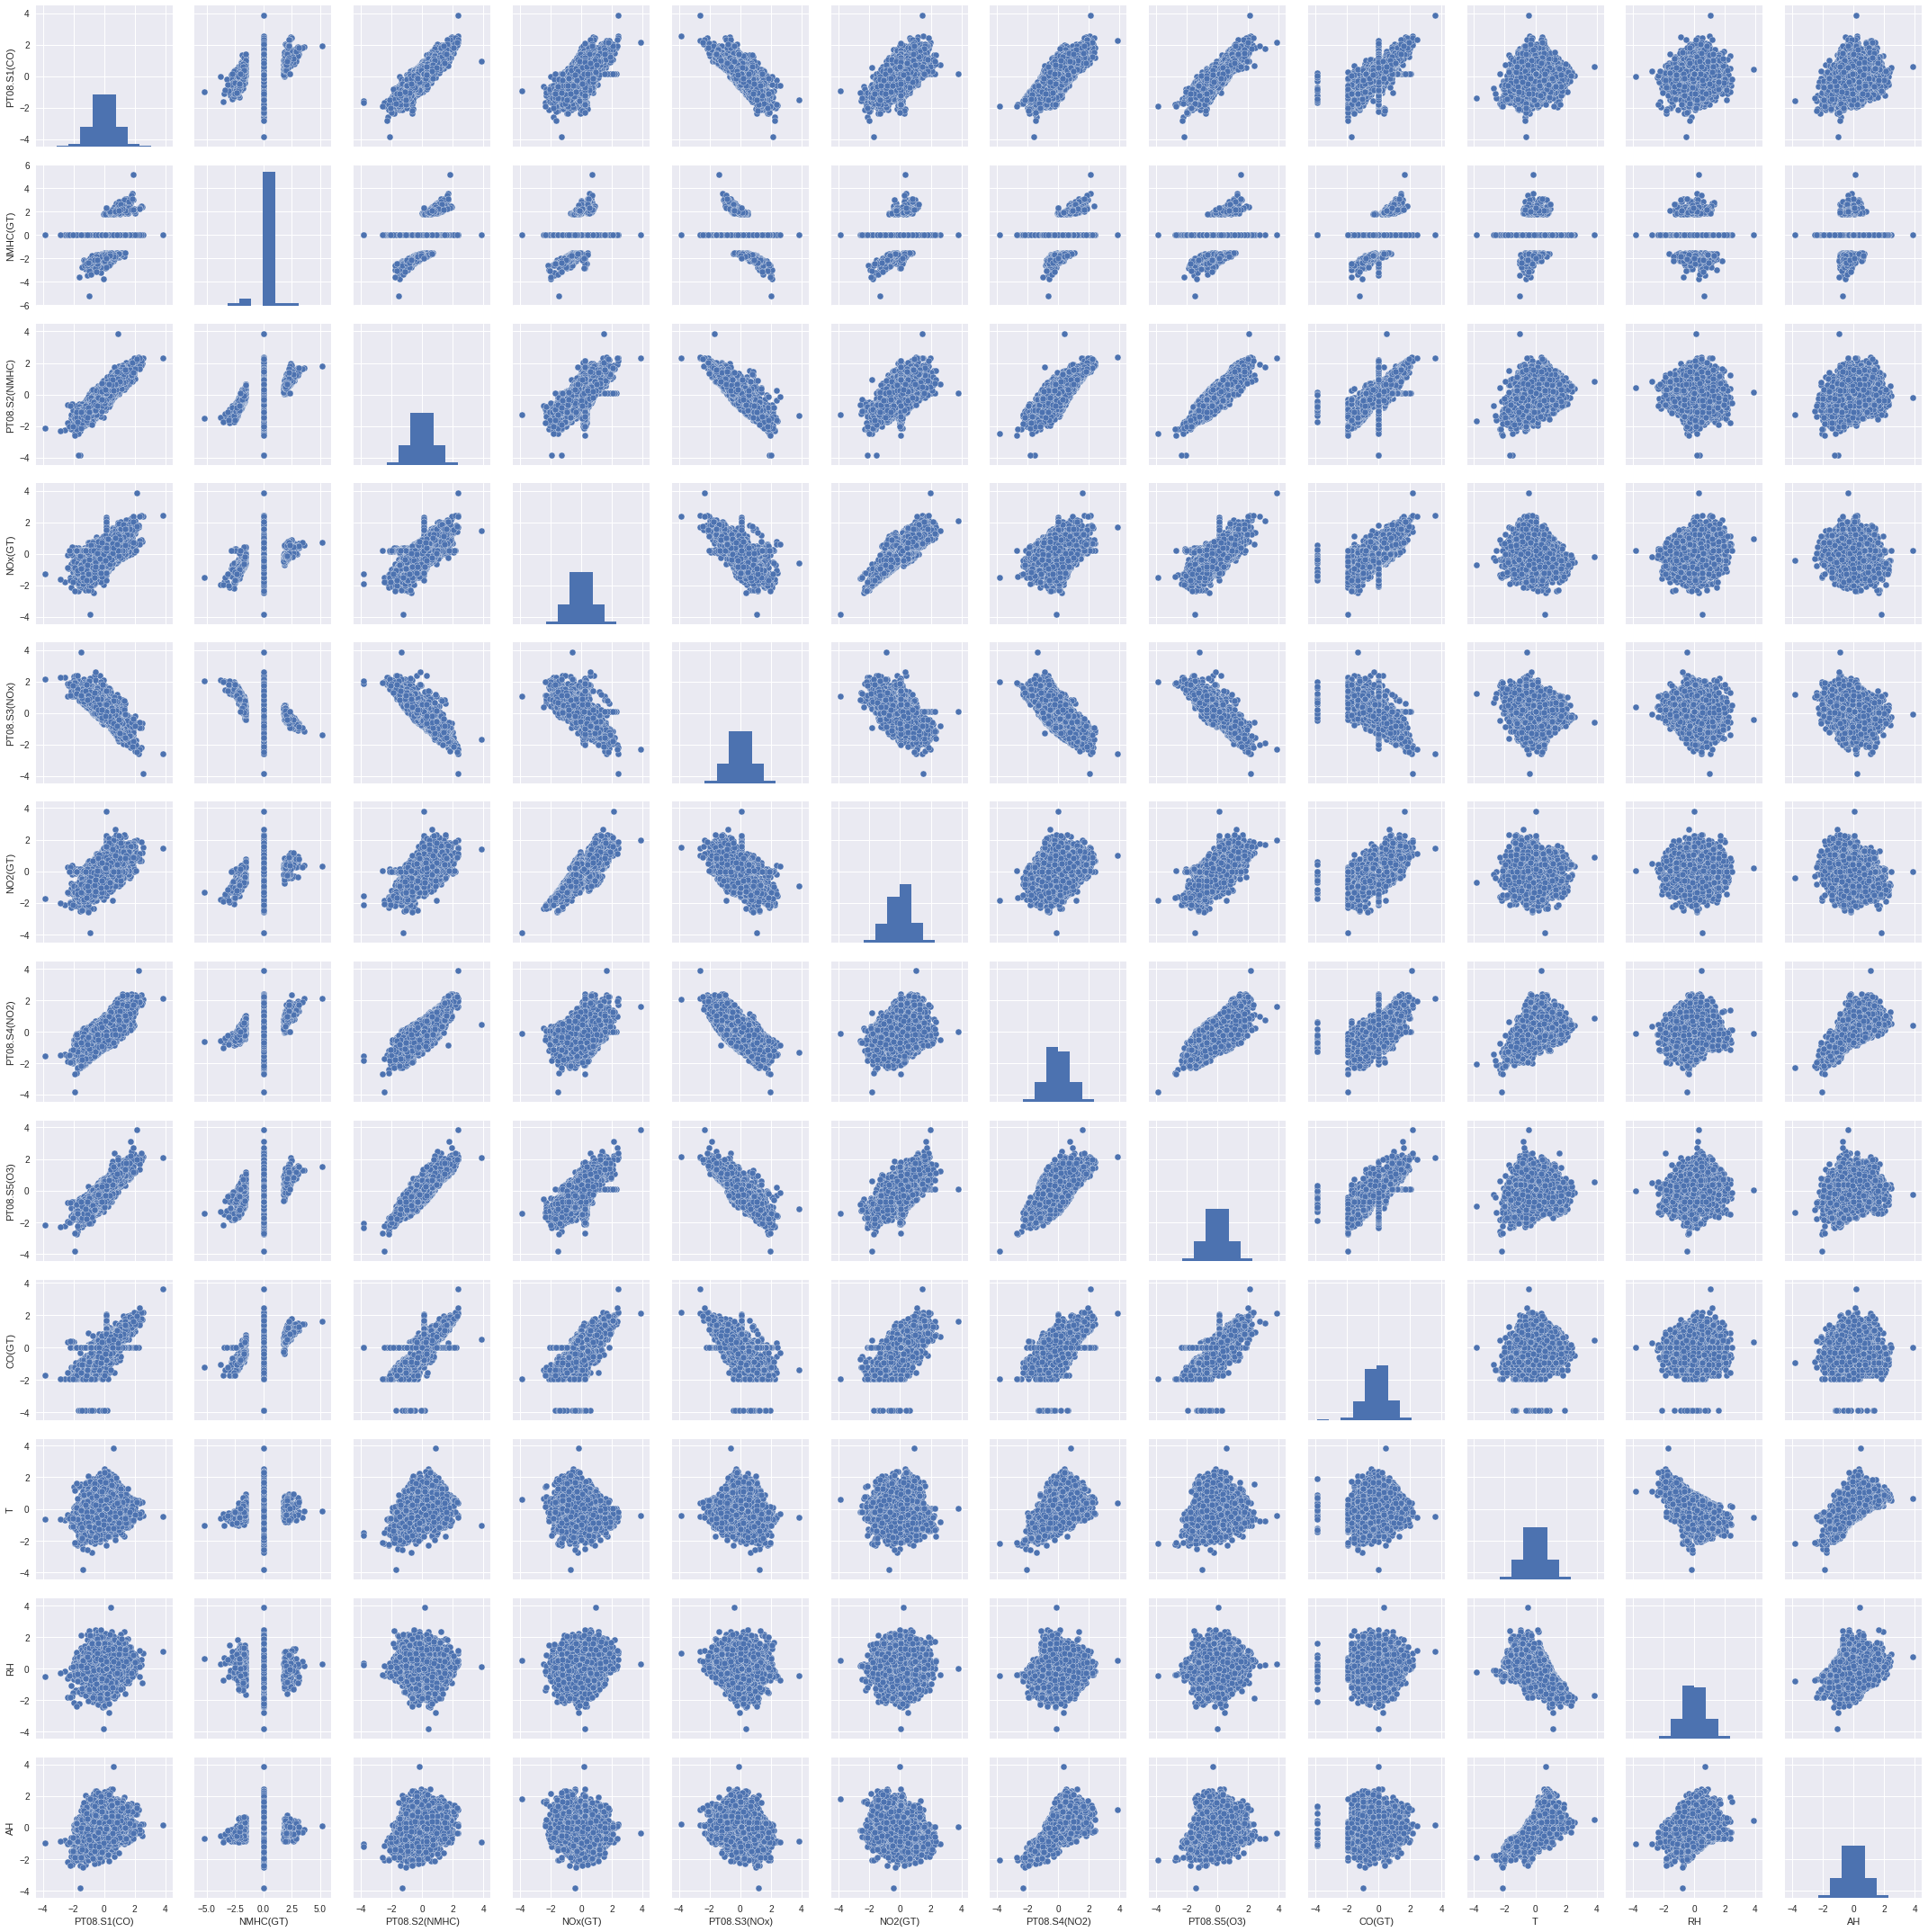

In [44]:
sns.pairplot(df_X_train_scaled)
plt.show()

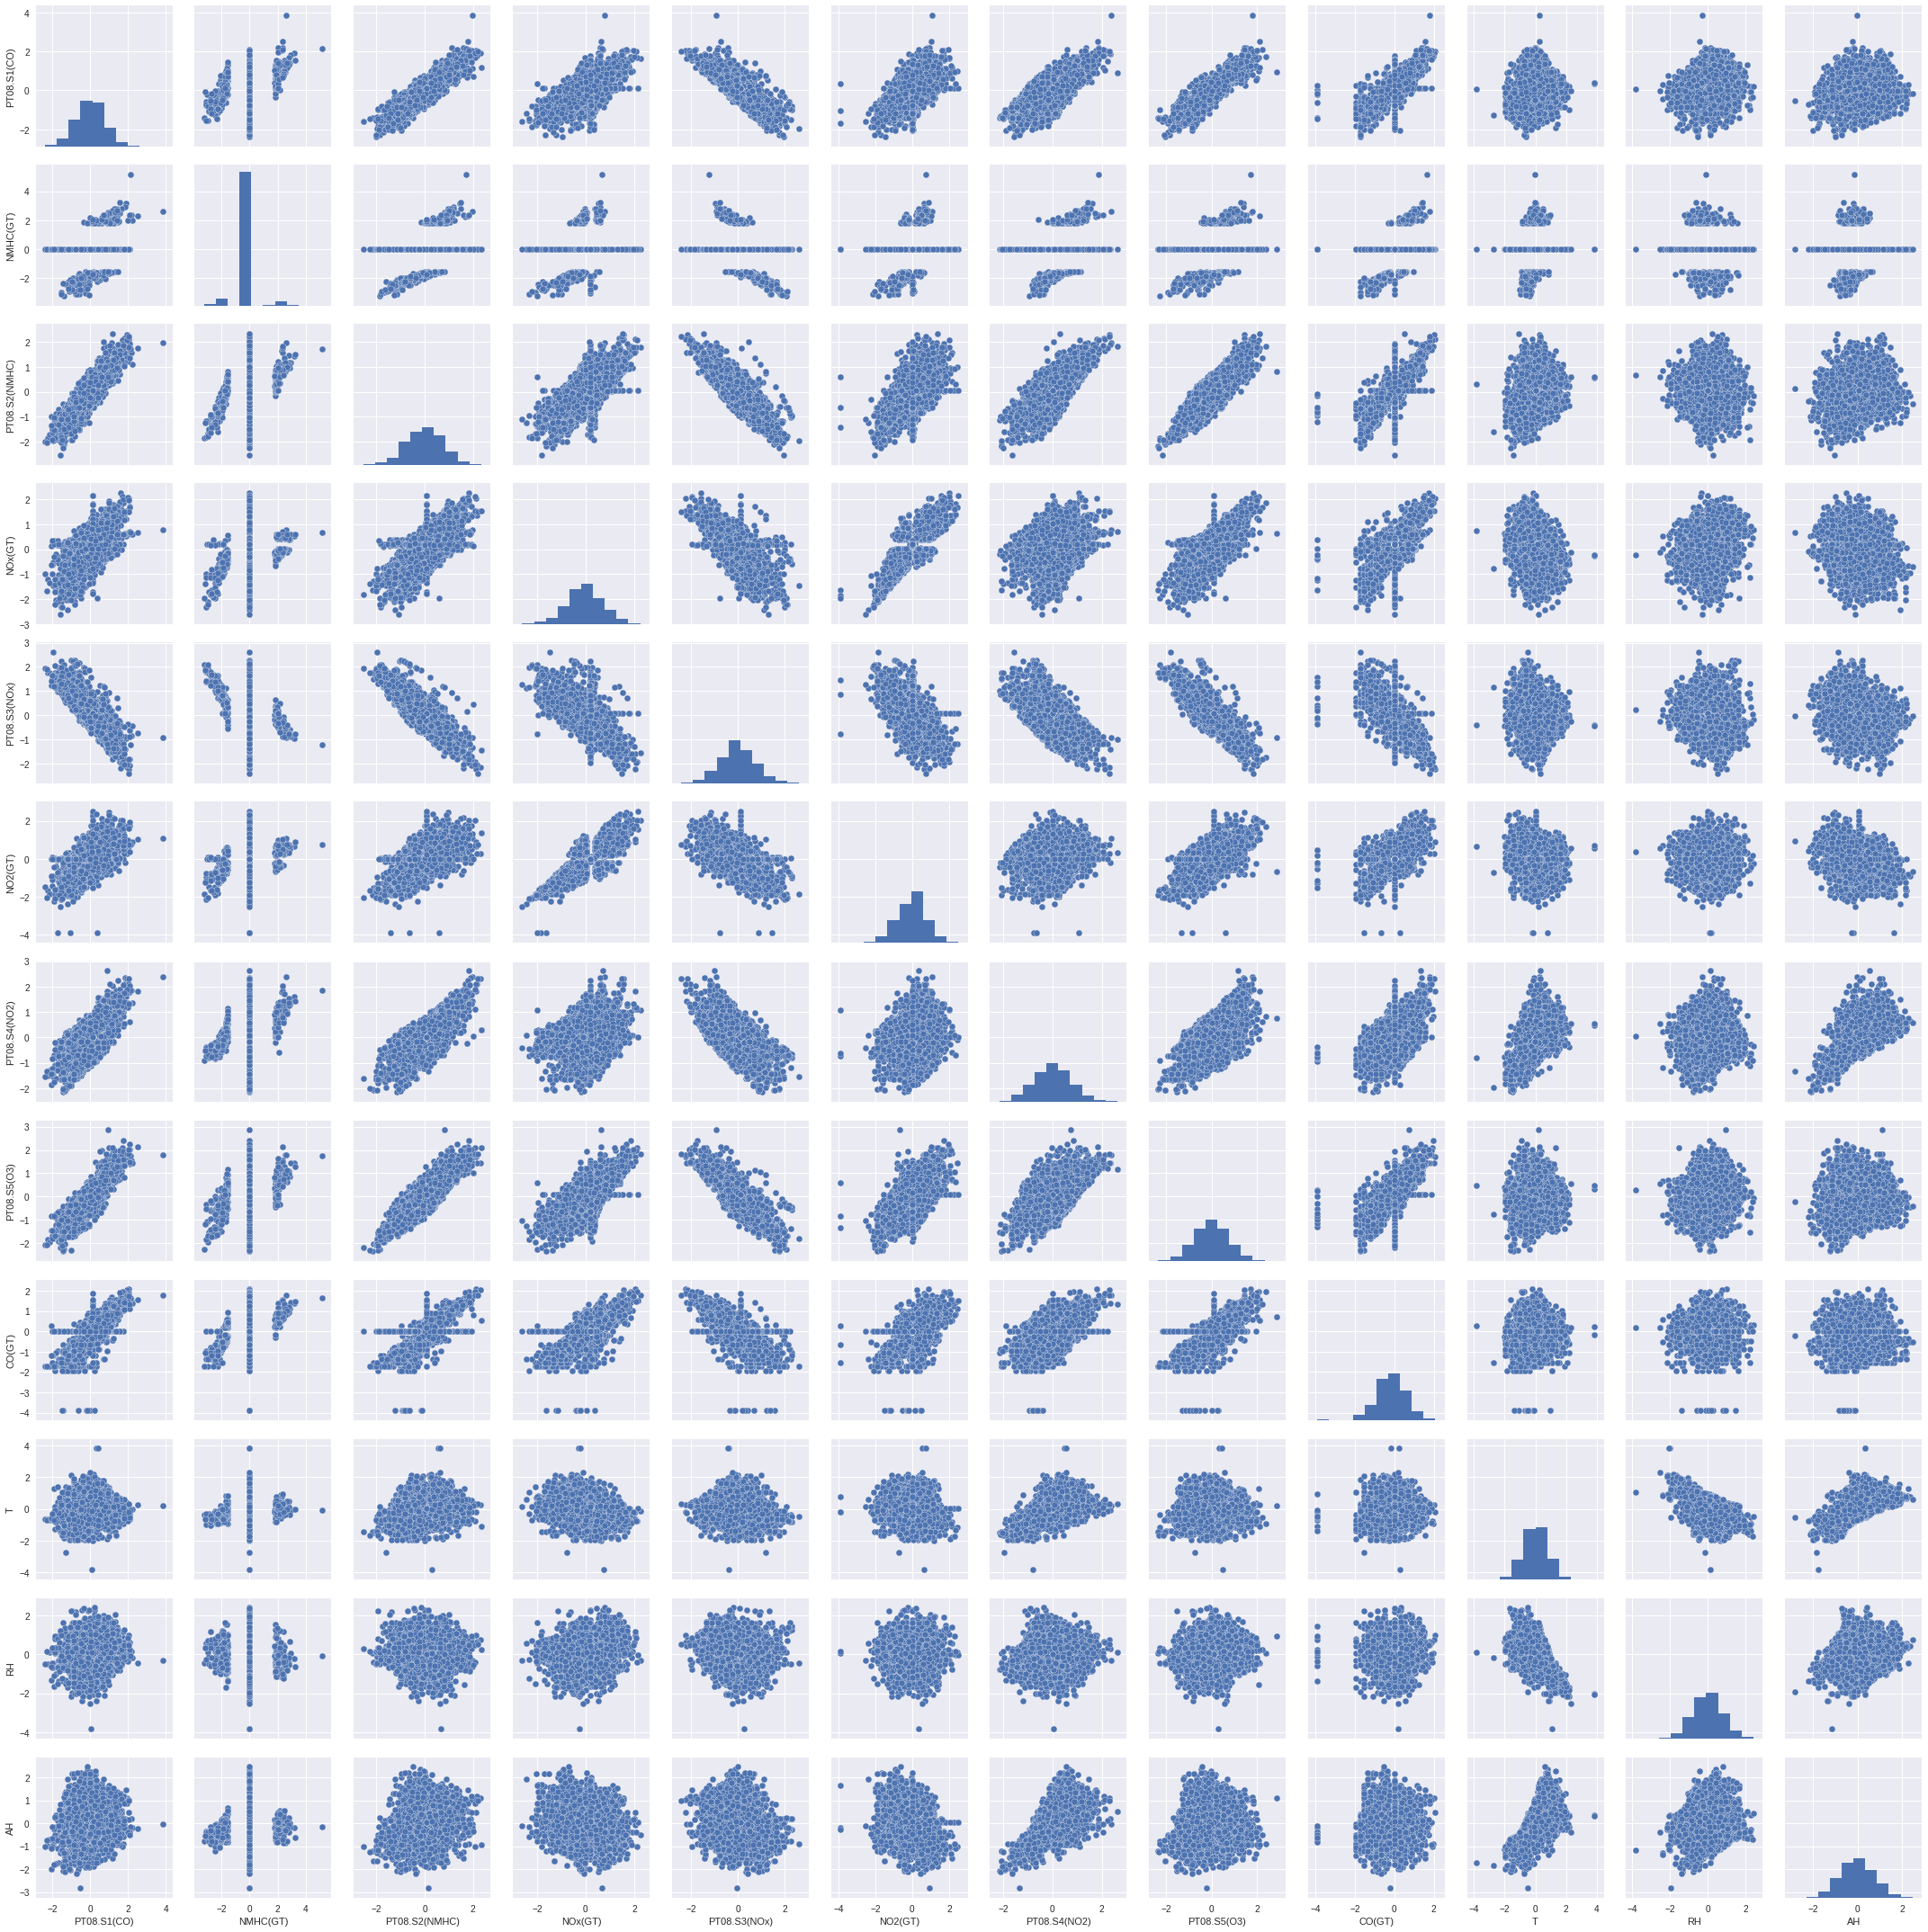

In [45]:
sns.pairplot(df_X_test_scaled)
plt.show()

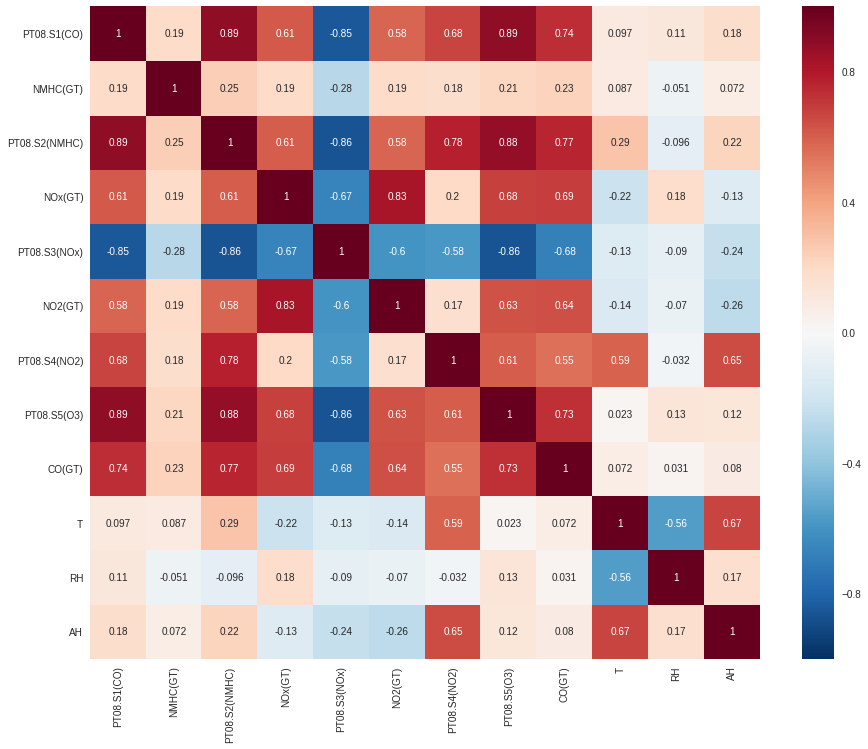

In [46]:
corr = df_X_train_scaled.corr()
plt.figure(figsize = (15, 12))
sns.heatmap(corr.applymap(lambda x: round(x, 4)), xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)

plt.xticks(rotation=90) 
plt.yticks(rotation=0) 
plt.show()

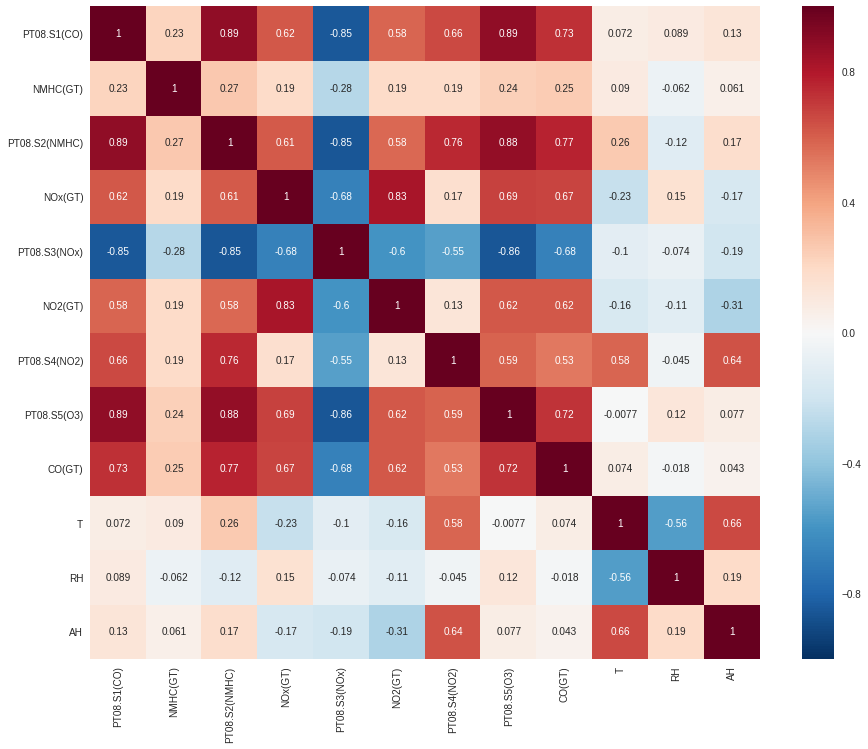

In [47]:
corr = df_X_test_scaled.corr()
plt.figure(figsize = (15, 12))
sns.heatmap(corr.applymap(lambda x: round(x, 4)), xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True)

plt.xticks(rotation=90) 
plt.yticks(rotation=0) 
plt.show()

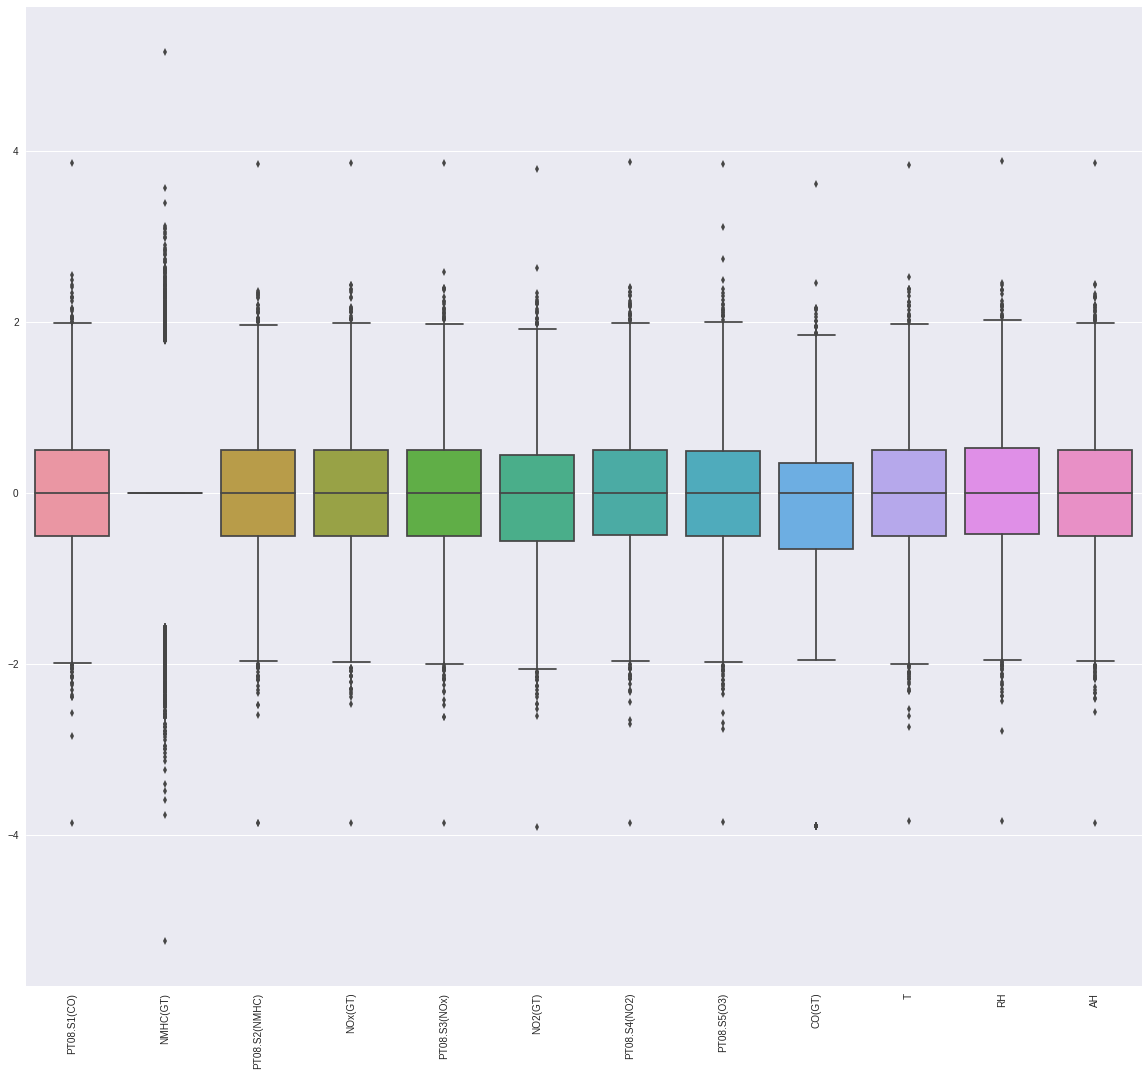

In [48]:
plt.figure(figsize = (20, 18))
sns.boxplot(data=df_X_train_scaled)
plt.xticks(rotation=90) 
plt.yticks(rotation=0) 
plt.show()

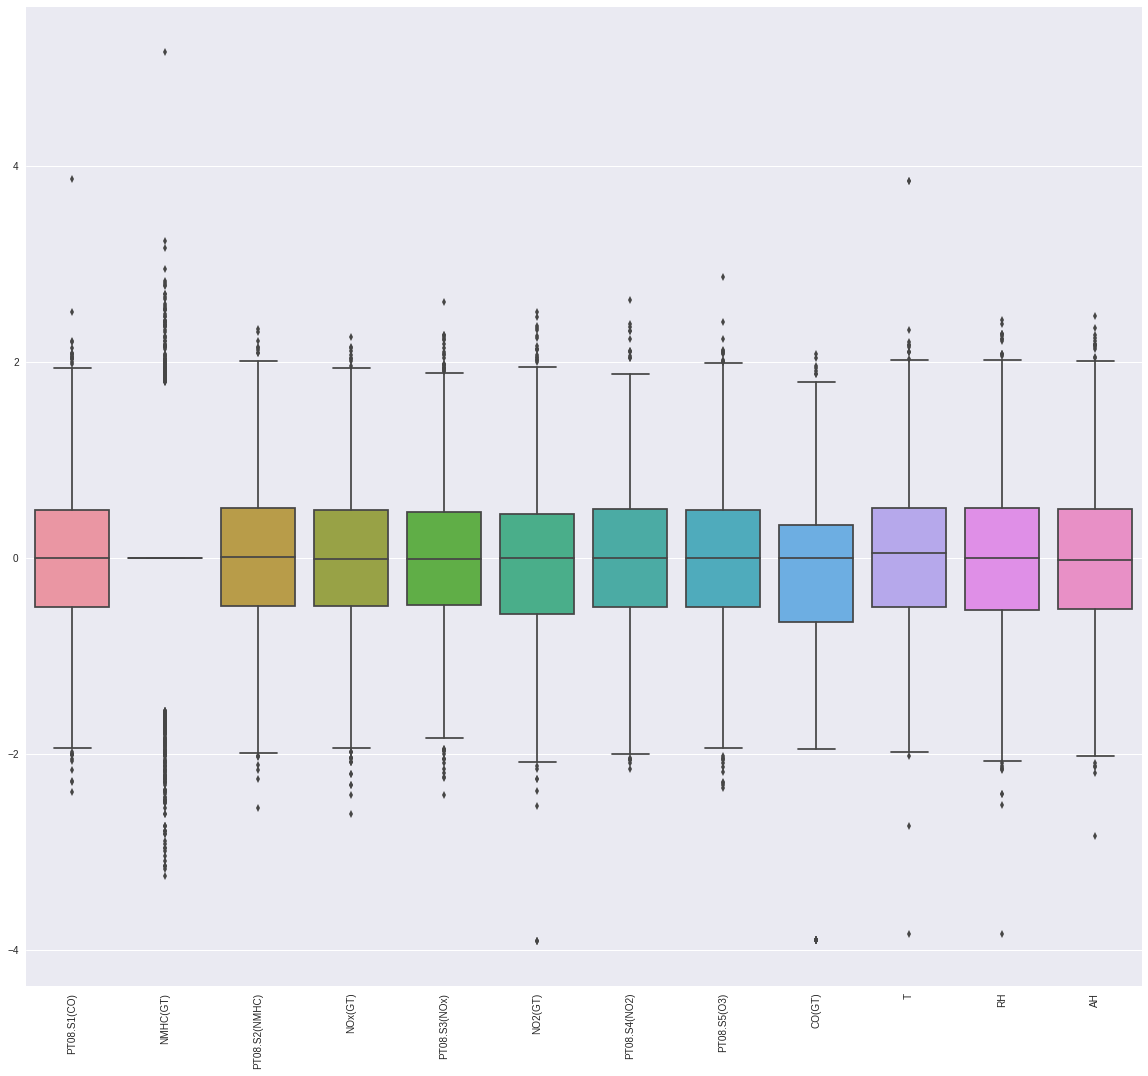

In [49]:
plt.figure(figsize = (20, 18))
sns.boxplot(data=df_X_test_scaled)
plt.xticks(rotation=90) 
plt.yticks(rotation=0) 
plt.show()

# Базовая модель

In [50]:
model = sm.OLS(y_train, df_X_train_scaled)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               C6H6(GT)   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     360.4
Date:                Wed, 17 Jan 2018   Prob (F-statistic):               0.00
Time:                        23:55:57   Log-Likelihood:                -23067.
No. Observations:                6269   AIC:                         4.616e+04
Df Residuals:                    6257   BIC:                         4.624e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
PT08.S1(CO)       0.3951      0.452      0.873

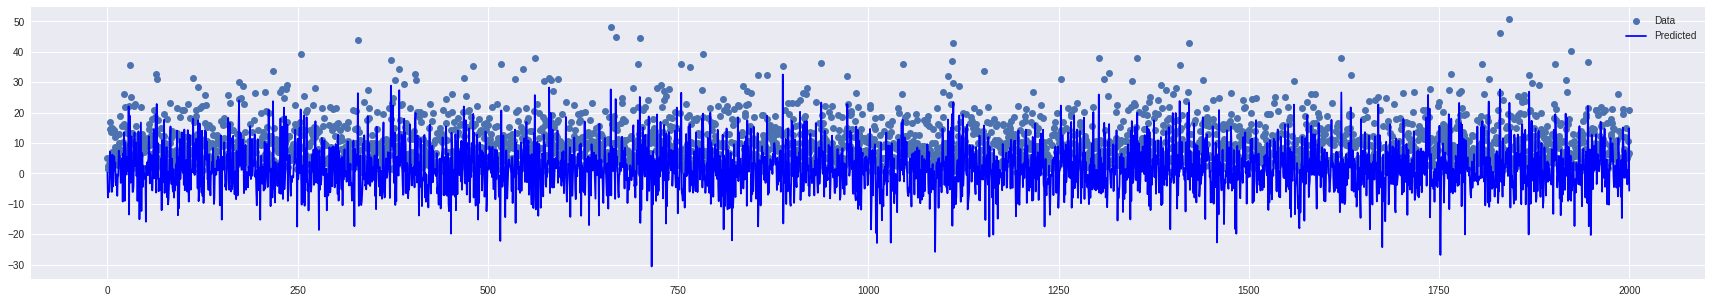

-0.759225851527


In [51]:
predicted = result.predict(df_X_test_scaled)

x1 = np.linspace(0, 2000, predicted.size)

plt.figure(figsize = (30, 5))
plt.plot(x1, y_test, 'o', label="Data")
plt.plot(x1, predicted, 'b-', label="Predicted")
plt.legend(loc="best")
plt.show()
print(r2_score(y_test, predicted, multioutput='variance_weighted'))

# Ridge регуляризация

In [53]:
ridge_model = sm.OLS(y_train, df_X_train_scaled)
ridge_result = ridge_model.fit_regularized(alpha=0.5, L1_wt=0)
print(ridge_result.summary())

                            OLS Regression Results                            
Dep. Variable:               C6H6(GT)   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     232.8
Date:                Wed, 17 Jan 2018   Prob (F-statistic):               0.00
Time:                        23:57:11   Log-Likelihood:                -23557.
No. Observations:                6269   AIC:                         4.714e+04
Df Residuals:                    6257   BIC:                         4.722e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
PT08.S1(CO)       1.4906      0.489      3.047

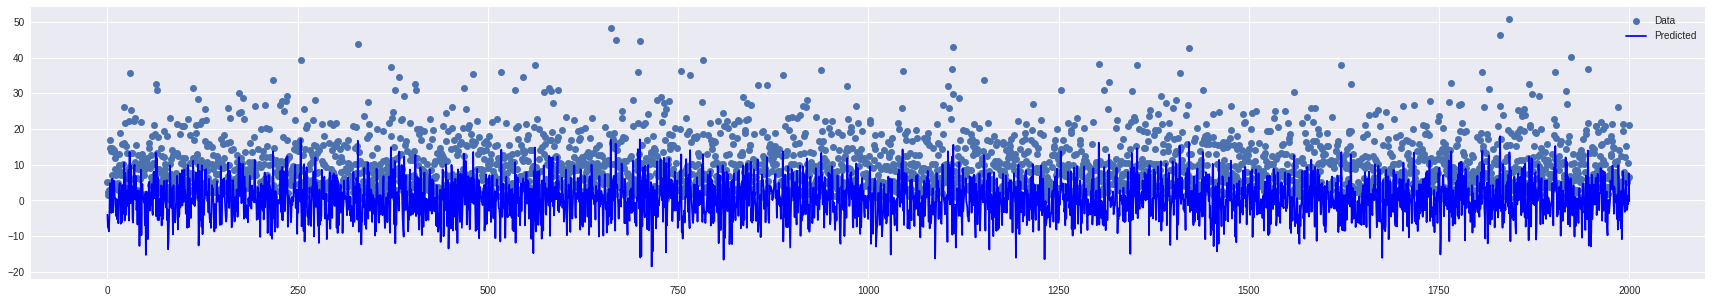

-1.06069645047


In [59]:
ridge_predicted = ridge_result.predict(df_X_test_scaled)

x1 = np.linspace(0, 2000, predicted.size)

plt.figure(figsize = (30, 5))
plt.plot(x1, y_test, 'o', label="Data")
plt.plot(x1, ridge_predicted, 'b-', label="Predicted")
plt.legend(loc="best")
plt.show()
print(r2_score(y_test, ridge_predicted, multioutput='variance_weighted'))

# Lasso регуляризация

In [57]:
lasso_model = sm.OLS(y_train, df_X_train_scaled)
lasso_result = lasso_model.fit_regularized(alpha=0.5, L1_wt=1)
print(lasso_result.summary())

                            OLS Regression Results                            
Dep. Variable:               C6H6(GT)   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     264.7
Date:                Wed, 17 Jan 2018   Prob (F-statistic):               0.00
Time:                        23:58:40   Log-Likelihood:                -23428.
No. Observations:                6269   AIC:                         4.688e+04
Df Residuals:                    6257   BIC:                         4.696e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
PT08.S1(CO)       0.3833      0.384      0.999

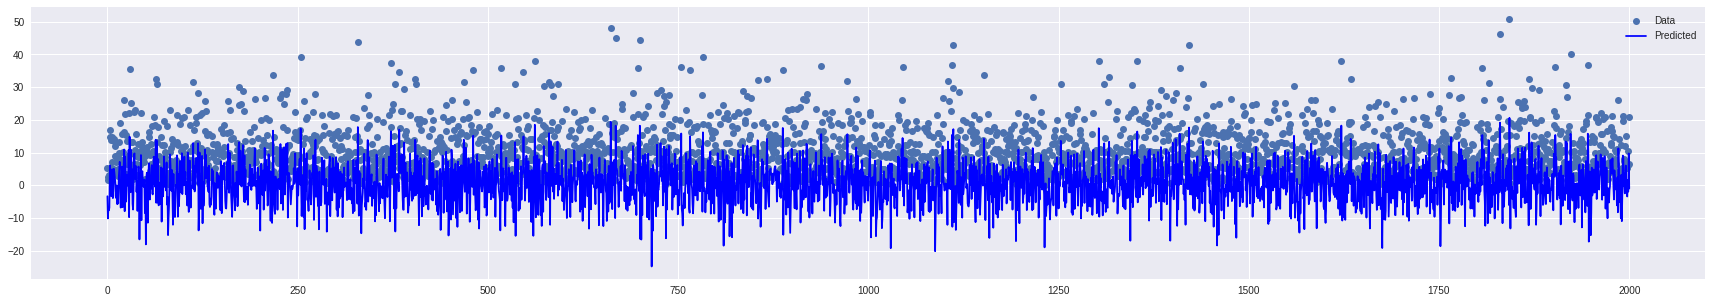

-0.951552681972


In [60]:
lasso_predicted = lasso_result.predict(df_X_test_scaled)

x1 = np.linspace(0, 2000, predicted.size)

plt.figure(figsize = (30, 5))
plt.plot(x1, y_test, 'o', label="Data")
plt.plot(x1, lasso_predicted, 'b-', label="Predicted")
plt.legend(loc="best")
plt.show()
print(r2_score(y_test, lasso_predicted, multioutput='variance_weighted'))